<a href="https://colab.research.google.com/github/SeongminCC/CNN_models/blob/main/5_DenseNet17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고링크 : https://velog.io/@lighthouse97/DenseNet%EC%9D%98-%EC%9D%B4%ED%95%B4

# modules import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

from torchsummary import summary as summary_

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import math

  - 현재 GPU 설정

In [ ]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

# 전처리 설정



In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.ToTensor()
])


# 데이터 로드 및 확인

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='/data',
                                       train=False,
                                       download=True,
                                       transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(testset,
                         batch_size=100,
                         shuffle=True,
                         num_workers=2)

In [ ]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([64, 3, 32, 32])


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

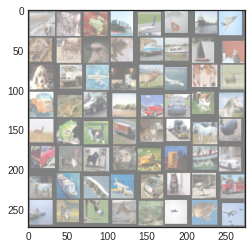

torch.Size([64, 3, 32, 32])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, lables = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(images.shape)

# 신경망 구성

**ResNet의 문제점들**
- Conv layer들이 너무 많이 쌓이게 되면 필터를 너무 많이 거치게 되면서

    모델이 한참 이전의 레이어와 이후의 레이어 간의 의미있는 논리를 합해서 전해하지 못한다.

    이를 위해 이전 레이어에서 다음 레이어를 바로 이어주는 추가적인 Connection을 만듬

    'xl = Hl(xl-1) + xl-1'

- 하지만 resnet은 이전 레이어의 output을 다음의 레이어의 output과 add한다는 점이

    정보들이 이후의 레이어들로 온전히 흘러가는 것을 방해하게 됨

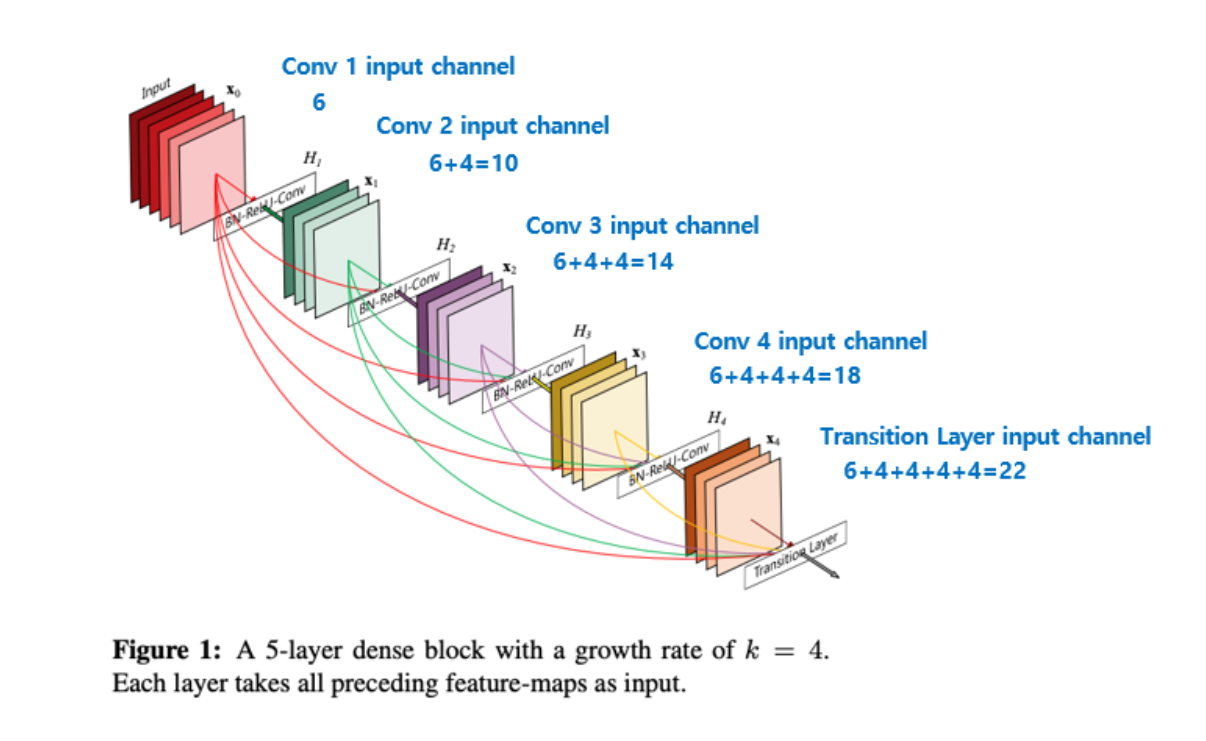

- DenseNet은 정보가 흘러가는 것을 개선하기 위해 ResNet과 다른 연결방식을 지원함
- ResNet처럼 이전의 레이어의 output을 add하는 것이 아닌 

    이전의 레이어의 output을 이후의 레이어의 input으로 받아오는 방식을 지원(concatenation)

    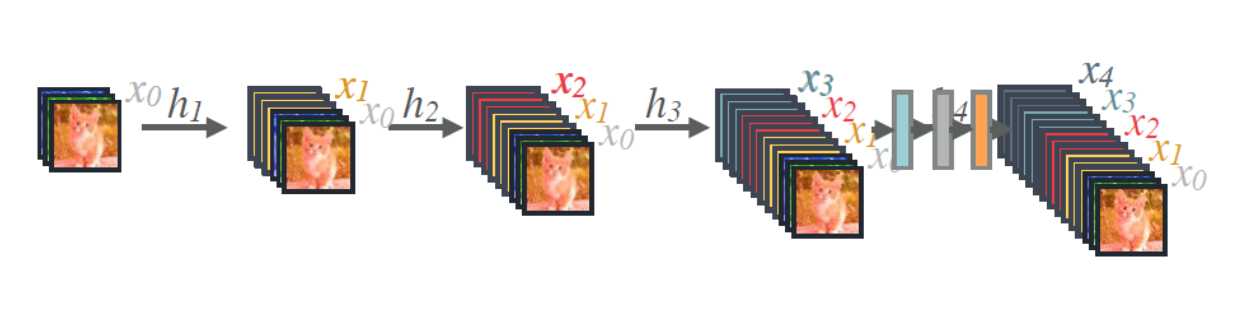

DenseNet은 위에서 더 나아가 **이어붙인 Connection의 덩어리**를 하나의 Block으로 만들었다.
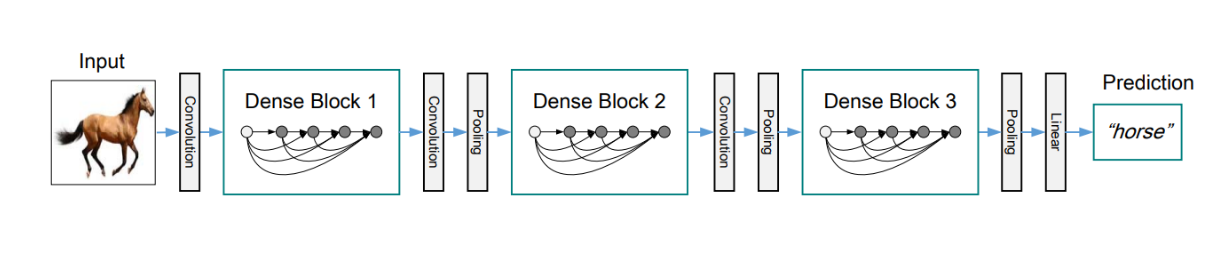

**위 구조로 얻을 수 있는 이점**

- Vanishing Gradient 개선
- Feature Propagation 강화
- Feature Reuse
- Parameter 수 절약

**DenseNet에서도 GoogLeNet(inception module)과 ResNet에서 사용되었던 Bottleneck을 사용한다.**

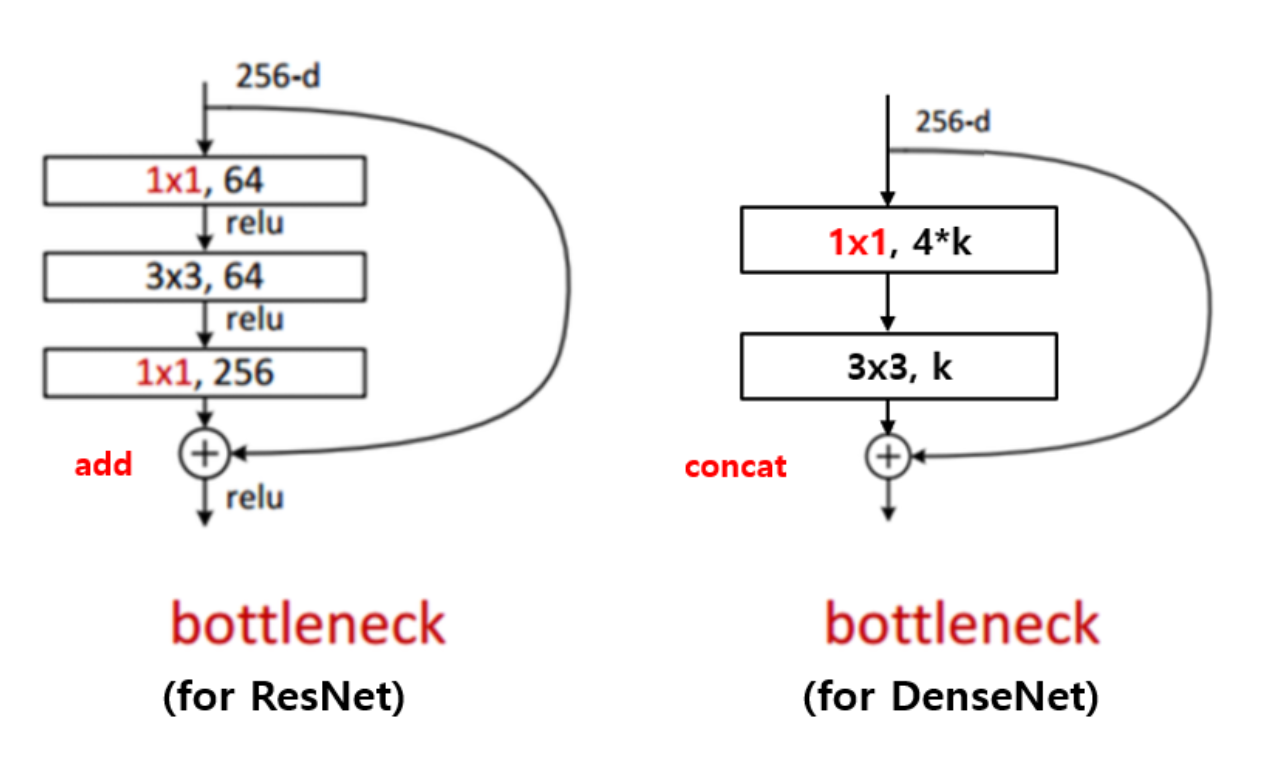

**DenseNet의 전체적인 아키텍처**

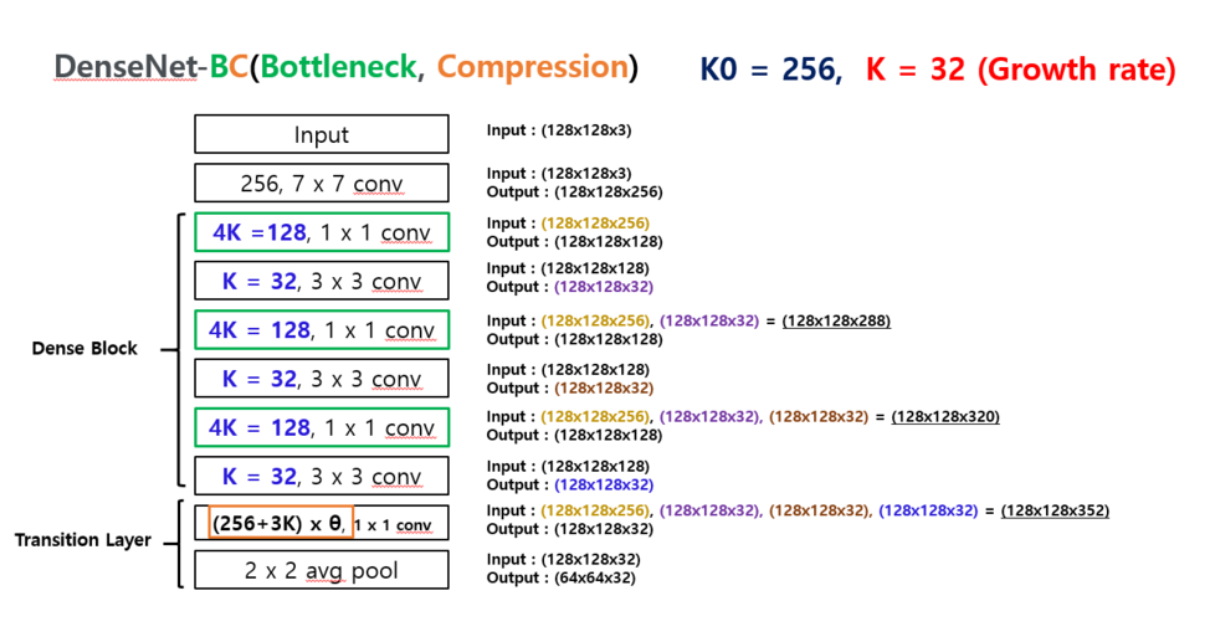

- k인 Growth rate는 생성하고자 하는 feature map의 개수
- 4 * K 에서의 4배를 해주는 것 역시 하이퍼 파라미터이다(왜 4배인지는 따로 설명 x)


**DenseNet 의 전체적인 구조**

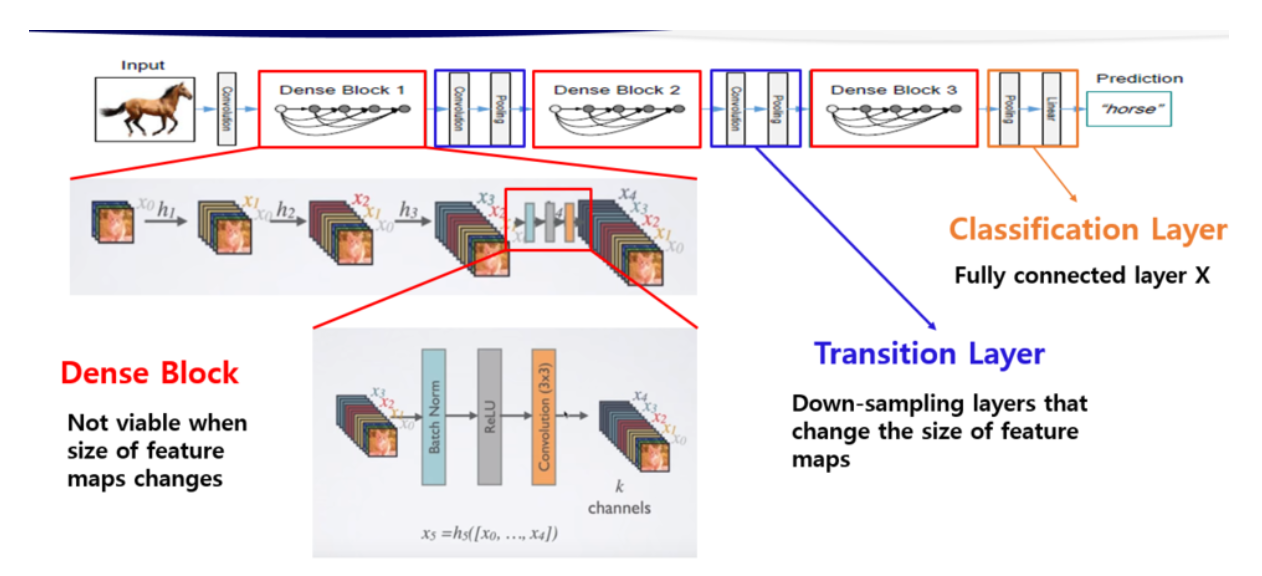

**Bottle neck 이 적용된 모습**

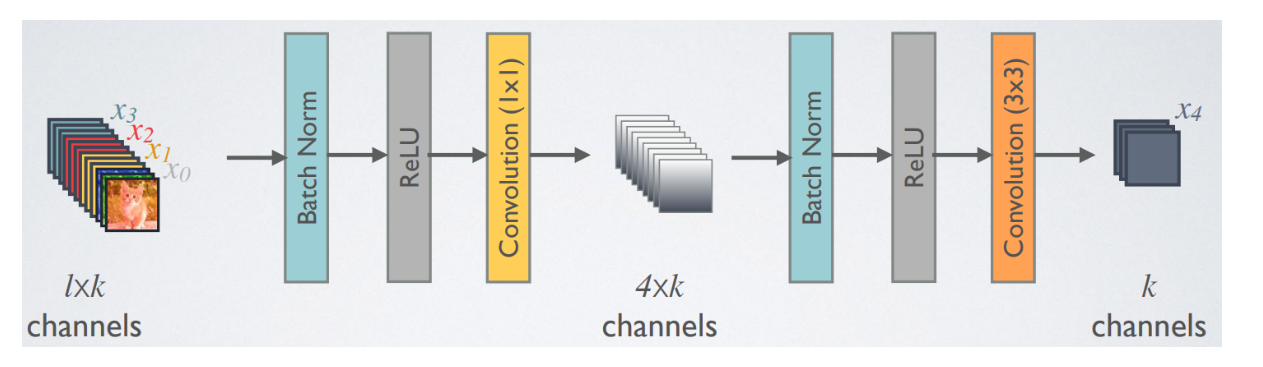

# DenseNet architecture

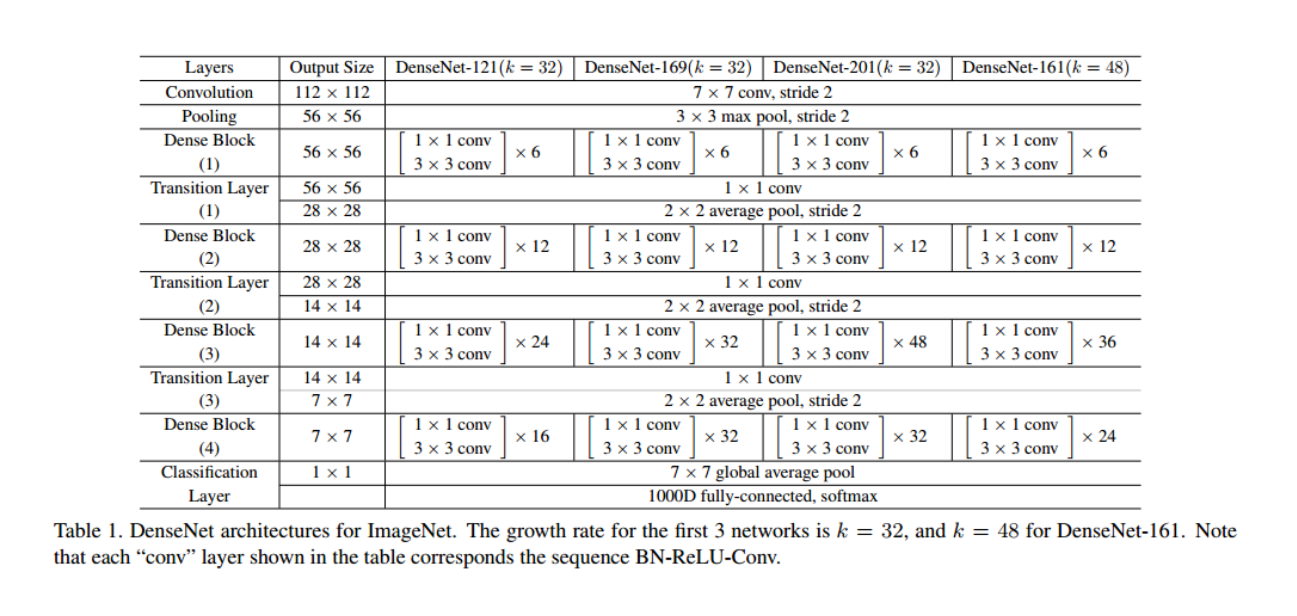

# 코드 구현

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)  # 1x1 convolution을 할 때는 output 채널 값이 4*k 가 되도록 함
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)   # size를 맞추기 위해 padding값을 1로 지정

    def forward(self, x):  # pre-activation resnet의 순서 (Batch Normalization - ReLU - Convolution)
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out, x], 1)  # 입력값과 출력값을 concatenation 해준다.

        return out

class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):  # Batch Normalization - Relu - 1×1 Convolution - 2×2 Average Pooling
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)

        return out

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):  # reduction : 논문의 theta
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate   
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)   # architecture 구현 시 padding=3 -> 7x7 filter 이므로 size를 맞추기 위함

        
        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate  # K0 + num_planes * K
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)


    def _make_dense_layers(self, block, in_planes, nblocks):
        layers=[]
        for i in range(nblocks):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate  # input과 output값이 concatenation 되었기 때문에 input의 in_planes와 output의 growth_rate를 더해준다.

        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.conv1(x)
        # out = self.max_pool2d(out, kernel_size=3, stride=2, padding=1) # 논문에서 max pooling layer
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)  # 논문에서는 7x7 GAP
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out



def DenseNet121():
    return DenseNet(Bottleneck, [6, 12, 24, 16], growth_rate=32)

net = DenseNet121()
net = net.to(device)
print(net)


DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

# 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)


In [ ]:
file_name = 'ResNet_cifar10.pth'

In [ ]:
def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += labels.size(0)
        current_correct = (predicted == labels).sum().item()
        correct += current_correct

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current batch average train accuracy:', current_correct / labels.size(0))
            print('Current batch average train loss:', loss.item() / labels.size(0))            
            

# 훈련이 모두 끝난 후 정확도 / 솔실함수 값을 출력  
    print('\nTotal average train accuarcy:', correct / total)
    print('Total average train loss:', train_loss / total)

def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            total += labels.size(0)

            outputs = net(inputs)
            loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()

        print('\nTotal average test accuarcy:', correct / total)
        print('Total average test loss:', loss / total)

        state = {
            'net' : net.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + file_name)
        print('Model Saved!')

In [ ]:
import time
import os

# 학습 수(epoch)가 많아지면 learning rate를 점점 줄여 손실함수가 떨어지지 않음을 방지한다.
def adjust_learning_rate(optimizer, epoch):
  lr = 0.1
  if epoch >= 50:
    lr /= 10
  if epoch >= 100:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

start_time = time.time()

for epoch in range(0, 10):
    train(epoch)
    test(epoch)
    print('\tTime elapsed:', time.time()-start_time)


[ Train epoch: 0 ]

Current batch: 0
Current batch average train accuracy: 0.125
Current batch average train loss: 0.035941231995821

Current batch: 100
Current batch average train accuracy: 0.234375
Current batch average train loss: 0.03450564295053482

Current batch: 200
Current batch average train accuracy: 0.234375
Current batch average train loss: 0.029240481555461884

Current batch: 300
Current batch average train accuracy: 0.421875
Current batch average train loss: 0.02661244198679924

Current batch: 400
Current batch average train accuracy: 0.296875
Current batch average train loss: 0.027808843180537224

Current batch: 500
Current batch average train accuracy: 0.390625
Current batch average train loss: 0.023690447211265564

Current batch: 600
Current batch average train accuracy: 0.46875
Current batch average train loss: 0.023856215178966522

Current batch: 700
Current batch average train accuracy: 0.5
Current batch average train loss: 0.024704478681087494

Total average train

**Test Accuracy : 80.95%**

**Test Loss : 0.00561**

**걸린 시간 : 약 30분**